In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/sameday.csv')[:-1]
 #data.plot(color='red')

In [ ]:
for i in data.select_dtypes('object').columns:
   le = LabelEncoder().fit(data[i])
   data[i] = le.transform(data[i])
data

,time,power,pix
0,1081,0.0,0
1,1082,0.0,0
2,1083,0.0,0
3,1084,0.0,0
4,1085,0.0,0
...,...,...,...
12475,1076,0.0,0
12476,1077,0.0,0
12477,1078,0.0,0
12478,1079,0.0,0


Index(['time', 'power', 'pix'], dtype='object')
12480


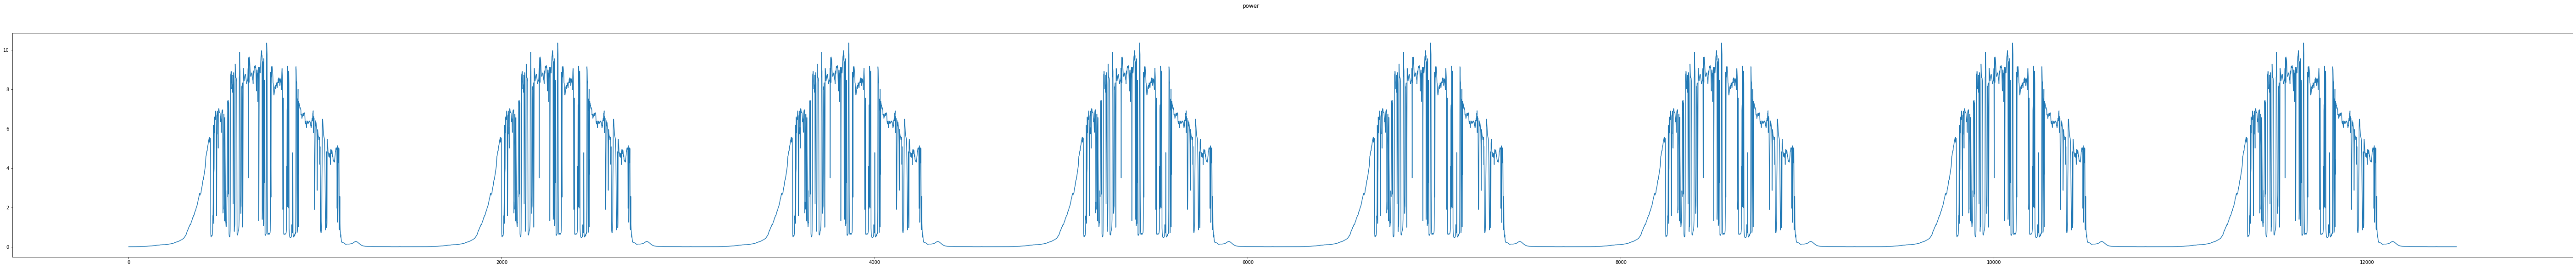

In [ ]:
data.columns
print(data.columns)
all_data = data['power'].values.astype(float)
print(len(all_data))

#training_set = training_set.iloc[:,1:2].values
plt.figure(figsize=(100,9))
plt.plot(all_data)

#plt.plot(power, label = 'AVG power2')
plt.suptitle('power')
plt.show()


Index(['time', 'power', 'pix'], dtype='object')
12480


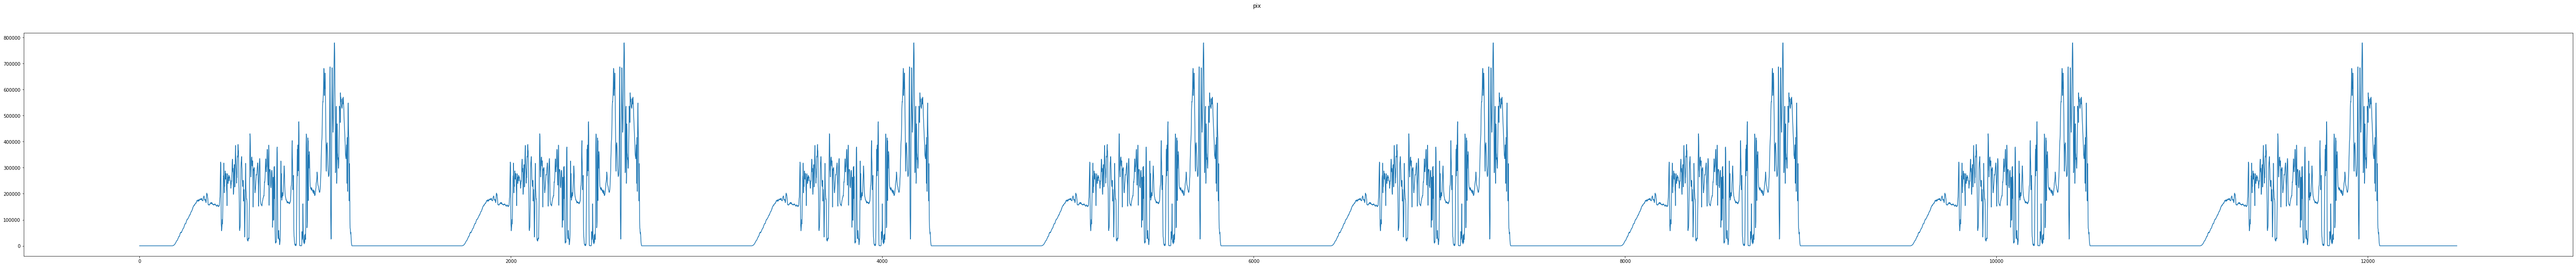

In [ ]:
data.columns
print(data.columns)
pix_data = data['pix'].values.astype(float)

print(len(all_data))
plt.figure(figsize=(100,9))

plt.plot(pix_data)

plt.suptitle('pix')
plt.show()


Index(['time', 'power', 'pix'], dtype='object')
12480


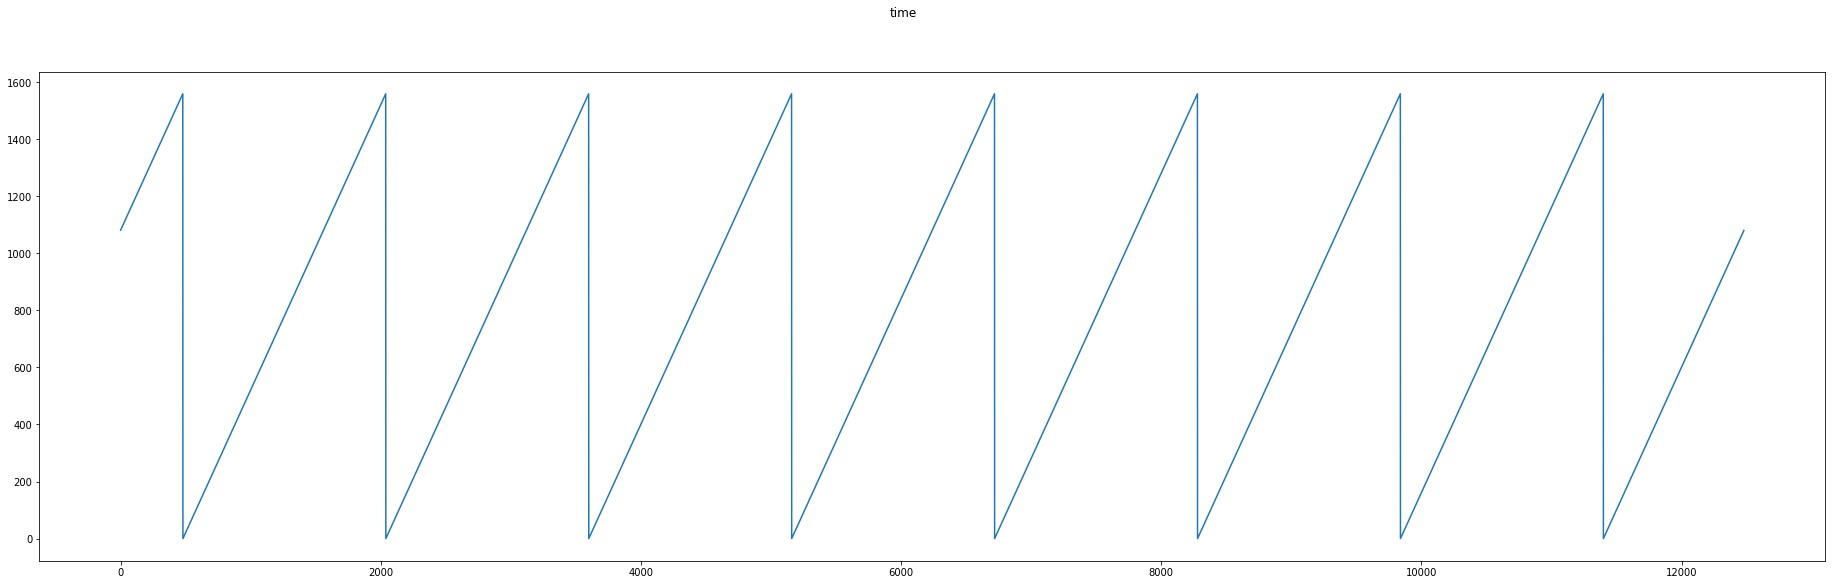

In [ ]:
data.columns
print(data.columns)
pix_data = data['time'].values.astype(float)

print(len(all_data))
plt.figure(figsize=(32,9))

plt.plot(pix_data)

plt.suptitle('time')
plt.show()

In [ ]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[['pix']])
X_data1 = X_scaler.fit_transform(data[['time']])
Y_data = Y_scaler.fit_transform(data[['power']]) #np.array(data[['power']])#
X_data
Y_data

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
       end = len(dataset) - horizon
    for i in range(start, end):
       indices = range(i-window, i)
       X.append(dataset[indices])
       #print(X)
       indicey = range(i+1, i+1+horizon)
       y.append(target[indicey][-1])
    return np.array(X), np.array(y)

In [ ]:
hist_window = 80
horizon = 20
TRAIN_SPLIT = int(len(X_data)*0.7)

x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

x_train1, y_train1 = custom_ts_multi_data_prep(X_data1, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali1, y_vali1 = custom_ts_multi_data_prep(X_data1, Y_data, TRAIN_SPLIT, None, hist_window, horizon)
print(len(x_train),len(x_train1))
#len(Y_data)

8656 8656


In [ ]:
#print ('Multiple window of past history\n')
#print(x_train[0])
#print ('\n Target horizon\n')
#print (y_train[0])

In [ ]:
batch_size = 64
buffer_size = 10
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

train_data1 = tf.data.Dataset.from_tensor_slices((x_train1, y_train1))
train_data1 = train_data1.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data1 = tf.data.Dataset.from_tensor_slices((x_vali1, y_vali1))
val_data1 = val_data1.batch(batch_size).repeat()
val_data
x_train.shape[-2:]


(80, 1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True),input_shape=x_train.shape[-2:]),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)),
  # # #tf.keras.layers.Dropout(0.2),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= False)),
  #tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dense(8, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
 ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 80, 64)           8704      
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 80, 64)           24832     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 80, 32)           10368     
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 80, 32)           6272      
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 80, 16)          

In [ ]:
model_path = '/content/drive/MyDrive/SkyImageModel_rainyday.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [ ]:
history = lstm_model.fit(train_data,epochs=75,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/75
100/100 [==============================] - 62s 402ms/step - loss: 0.1352 - val_loss: 0.0924
Epoch 2/75
100/100 [==============================] - 38s 381ms/step - loss: 0.1057 - val_loss: 0.0587
Epoch 3/75
100/100 [==============================] - 37s 367ms/step - loss: 0.0826 - val_loss: 0.0562
Epoch 4/75
100/100 [==============================] - 35s 350ms/step - loss: 0.0786 - val_loss: 0.0572
Epoch 5/75
100/100 [==============================] - 37s 374ms/step - loss: 0.0876 - val_loss: 0.0519
Epoch 6/75
100/100 [==============================] - 35s 351ms/step - loss: 0.0744 - val_loss: 0.0639
Epoch 7/75
100/100 [==============================] - 35s 354ms/step - loss: 0.0799 - val_loss: 0.0470
Epoch 8/75
100/100 [==============================] - 35s 351ms/step - loss: 0.0724 - val_loss: 0.0476
Epoch 9/75
100/100 [==============================] - 37s 372ms/step - loss: 0.0712 - val_loss: 0.0470
Epoch 10/75
100/100 [==============================] - 35s 354ms/step - l

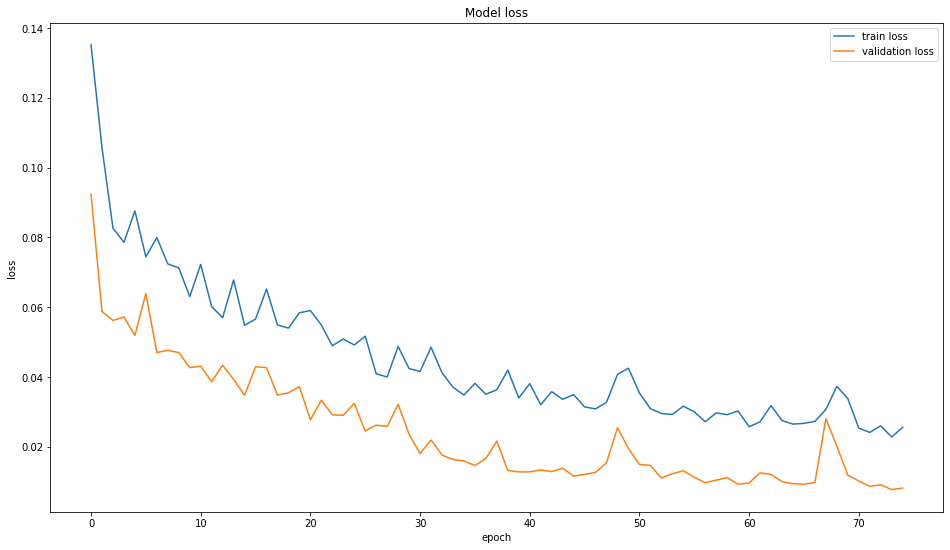

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
num = int(len(data[[ 'pix']])/7)

In [ ]:
data_val = X_scaler.fit_transform(data[[ 'pix']])[:num]
Expected = X_scaler.fit_transform(data[['power' ]])[:num]
print(len(Expected))
print(len(data_val))

1782
1782


In [ ]:
data_for_pred, Expected_val = custom_ts_multi_data_prep(data_val, Expected, 0, None, hist_window, horizon)

In [ ]:
pred = []
print(len(data_for_pred))

for i in data_for_pred:
  #print(len(i))
  #print(i.shpae)
  i = i.reshape(1, i.shape[0], i.shape[1])
  pred.append(lstm_model.predict(i))
  #break
#pred = np.array(pred)
pred[0][0]

1682


array([0.02657327], dtype=float32)

In [ ]:
act_pred =[]
for preds in pred:
  #print(preds)

  pred_Inverse = Y_scaler.inverse_transform(preds)
  act_pred.append(pred_Inverse)
len(act_pred)
#act_pred

1682

In [ ]:
predn = []
for item in list(act_pred):
  item = float(item[0])
  item = round(item, 2)
  predn.append(item)
  #print(item)
#pred

In [ ]:
Expected = Y_scaler.inverse_transform(Expected)
Expected
Expected_list = []
for item in list(Expected):
  Expected_list.append(float(item[0]))
  #print(item)
len(Expected)

1782

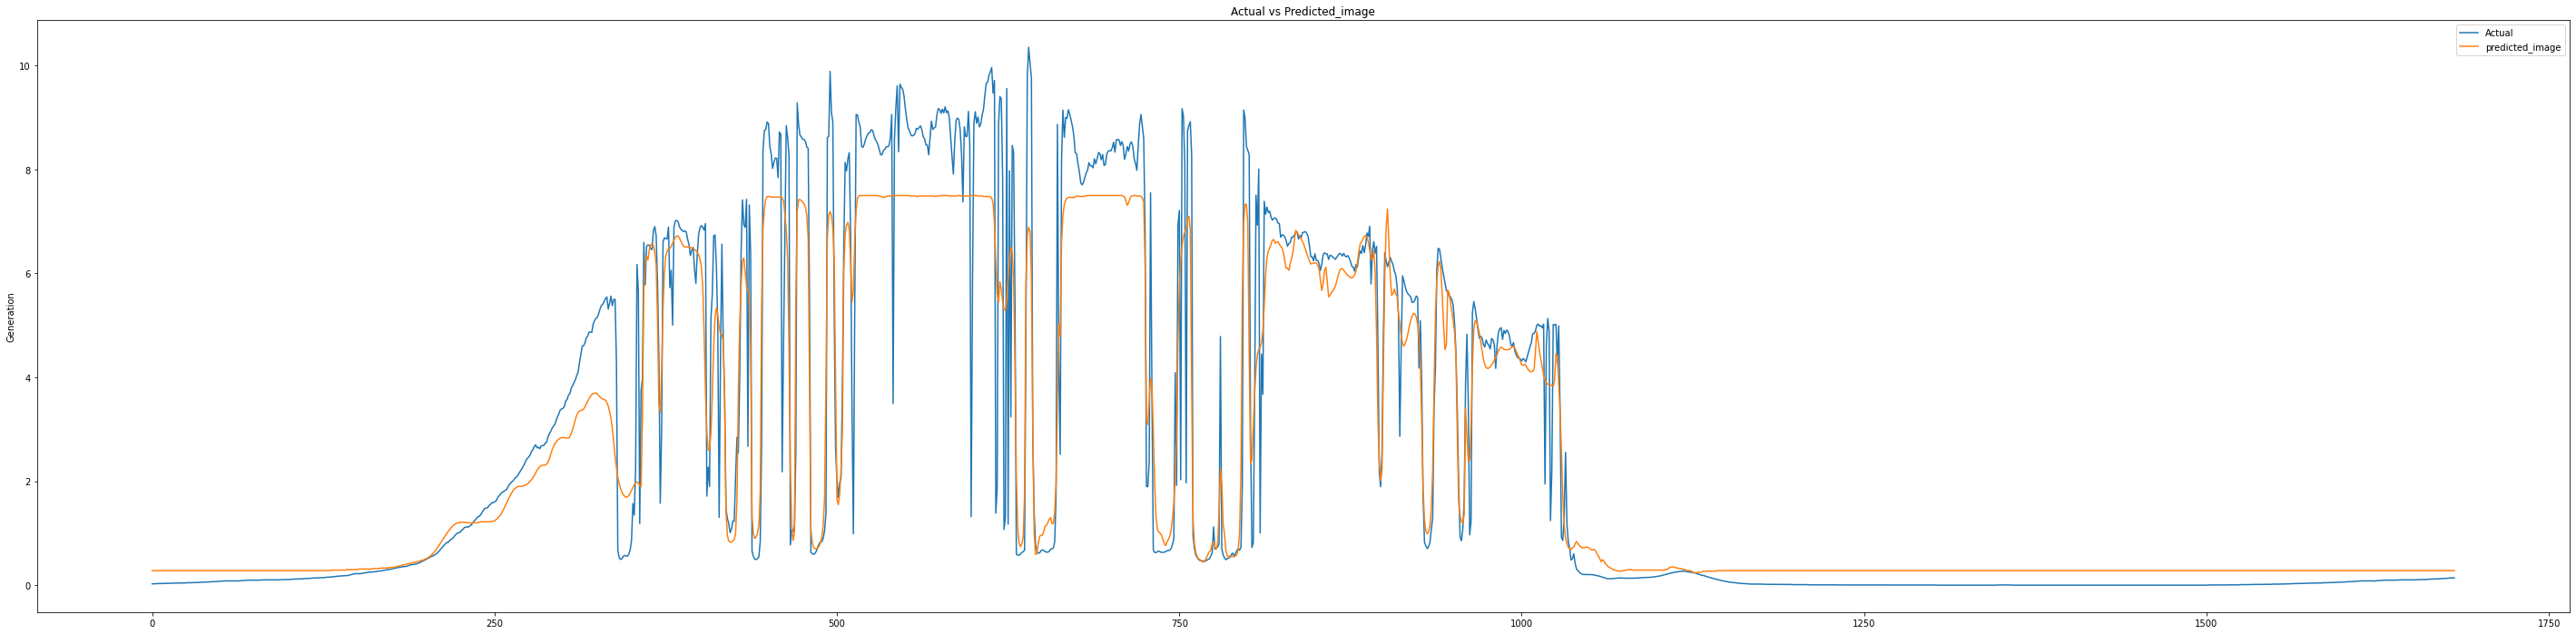

In [ ]:
plt.figure(figsize=(50,12))
#
plt.plot( list(Expected[len(Expected)-len(predn):]))
plt.plot(predn)
# plt.plot(pred1)
plt.title("Actual vs Predicted_image")
plt.ylabel("Generation")
plt.legend(('Actual','predicted_image'))
plt.show()

In [ ]:
lstm_model1 = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True),input_shape=x_train.shape[-2:]),
  #tf.keras.layers.Dropout(0.2),
  #  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences= True)),
  # #tf.keras.layers.Dropout(0.2),
  # # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences= True)),
  # # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences= False)),
  #tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dense(8, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  #tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dense(2, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
 ])
lstm_model1.compile(optimizer='adam', loss='mse')
lstm_model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_15 (Bidirecti  (None, 80, 64)           8704      
 onal)                                                           
                                                                 
 bidirectional_16 (Bidirecti  (None, 80, 32)           10368     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 16)               2624      
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                      

In [ ]:
model_path = '/content/drive/MyDrive/StatisticsModel_rainyday.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

In [ ]:
history = lstm_model1.fit(train_data1,epochs=50,steps_per_epoch=100,validation_data=val_data1,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - 34s 223ms/step - loss: 0.1525 - val_loss: 0.0899
Epoch 2/50
100/100 [==============================] - 18s 178ms/step - loss: 0.1131 - val_loss: 0.0605
Epoch 3/50
100/100 [==============================] - 18s 176ms/step - loss: 0.0811 - val_loss: 0.0621
Epoch 4/50
100/100 [==============================] - 18s 181ms/step - loss: 0.0812 - val_loss: 0.0593
Epoch 5/50
100/100 [==============================] - 18s 179ms/step - loss: 0.0932 - val_loss: 0.0580
Epoch 6/50
100/100 [==============================] - 18s 178ms/step - loss: 0.0778 - val_loss: 0.0552
Epoch 7/50
100/100 [==============================] - 18s 179ms/step - loss: 0.0833 - val_loss: 0.0555
Epoch 8/50
100/100 [==============================] - 20s 198ms/step - loss: 0.0653 - val_loss: 0.0622
Epoch 9/50
100/100 [==============================] - 18s 178ms/step - loss: 0.0743 - val_loss: 0.0454
Epoch 10/50
100/100 [==============================] - 18s 179ms/step - l

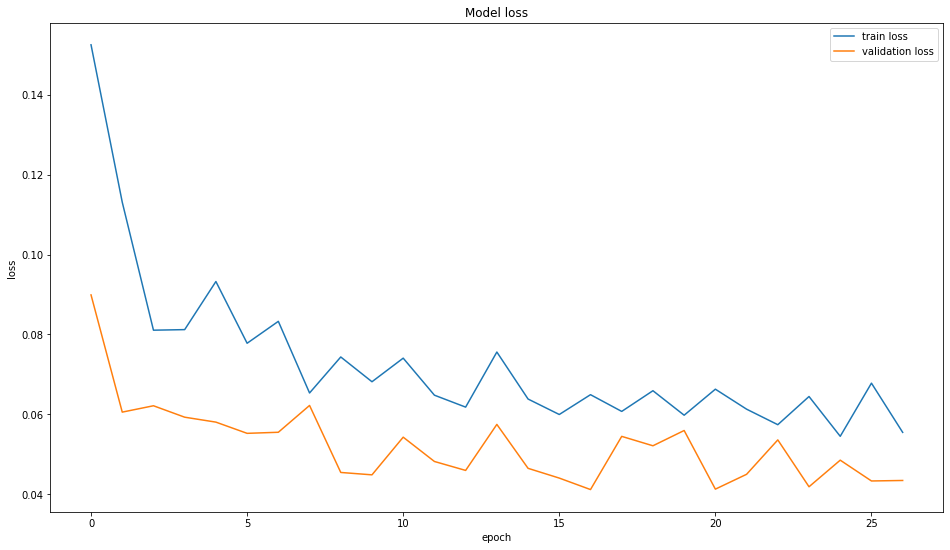

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
#num = int(len(data[[ 'pix']])*0.1)

In [ ]:
data_val = X_scaler.fit_transform(data[[ 'pix']])[:num]
Expected = X_scaler.fit_transform(data[['power' ]])[:num]
print(len(Expected))
print(len(data_val))

1782
1782


In [ ]:
data_val1 = X_scaler.fit_transform(data[[ 'time']])[:num]
Expected1 = X_scaler.fit_transform(data[['power' ]])[:num]
print(len(Expected1))
print(len(data_val1))

1782
1782


In [ ]:
data_for_pred, Expected_val = custom_ts_multi_data_prep(data_val, Expected, 0, None, hist_window, horizon)
data_for_pred1, Expected_val1 = custom_ts_multi_data_prep(data_val1, Expected1, 0, None, hist_window, horizon)
#data_for_pred[0], Expected_val[0]

In [ ]:
# len(data_for_pred)

In [ ]:
pred = []
print(len(data_for_pred))

for i in data_for_pred:
  #print(len(i))
  #print(i.shpae)
  i = i.reshape(1, i.shape[0], i.shape[1])
  pred.append(lstm_model.predict(i))
  #break
#pred = np.array(pred)
pred[0][0]

1682


array([0.02657327], dtype=float32)

In [ ]:
pred1 = []
print(len(data_for_pred1))

for i in data_for_pred1:
  #print(len(i))
  #print(i.shpae)
  i = i.reshape(1, i.shape[0], i.shape[1])
  pred1.append(lstm_model1.predict(i))
  #break
#pred = np.array(pred)
pred1[0][0]

1682


array([0.12294934], dtype=float32)

In [ ]:
#pred

In [ ]:
act_pred =[]
for preds in pred:
  #print(preds)

  pred_Inverse = Y_scaler.inverse_transform(preds)
  act_pred.append(pred_Inverse)
len(act_pred)
#act_pred

1682

In [ ]:
act_pred1 =[]
for preds in pred1:
  #print(preds)

  pred_Inverse = Y_scaler.inverse_transform(preds)
  act_pred1.append(pred_Inverse)
len(act_pred1)

1682

In [ ]:
predn = []
for item in list(act_pred):
  item = float(item[0])
  item = round(item, 2)
  predn.append(item)
  #print(item)
#pred

In [ ]:
predn1 = []
for item in list(act_pred1):
  item = float(item[0])
  item = round(item, 2)
  predn1.append(item)
  #print(item)
#pred

In [ ]:
len(Expected), len(pred)

(1782, 1682)

In [ ]:
Expected = Y_scaler.inverse_transform(Expected)
Expected
Expected_list = []
for item in list(Expected):
  Expected_list.append(float(item[0]))
  #print(item)
len(Expected)

1782

In [ ]:
Expected1 = Expected[len(Expected)-len(predn):]

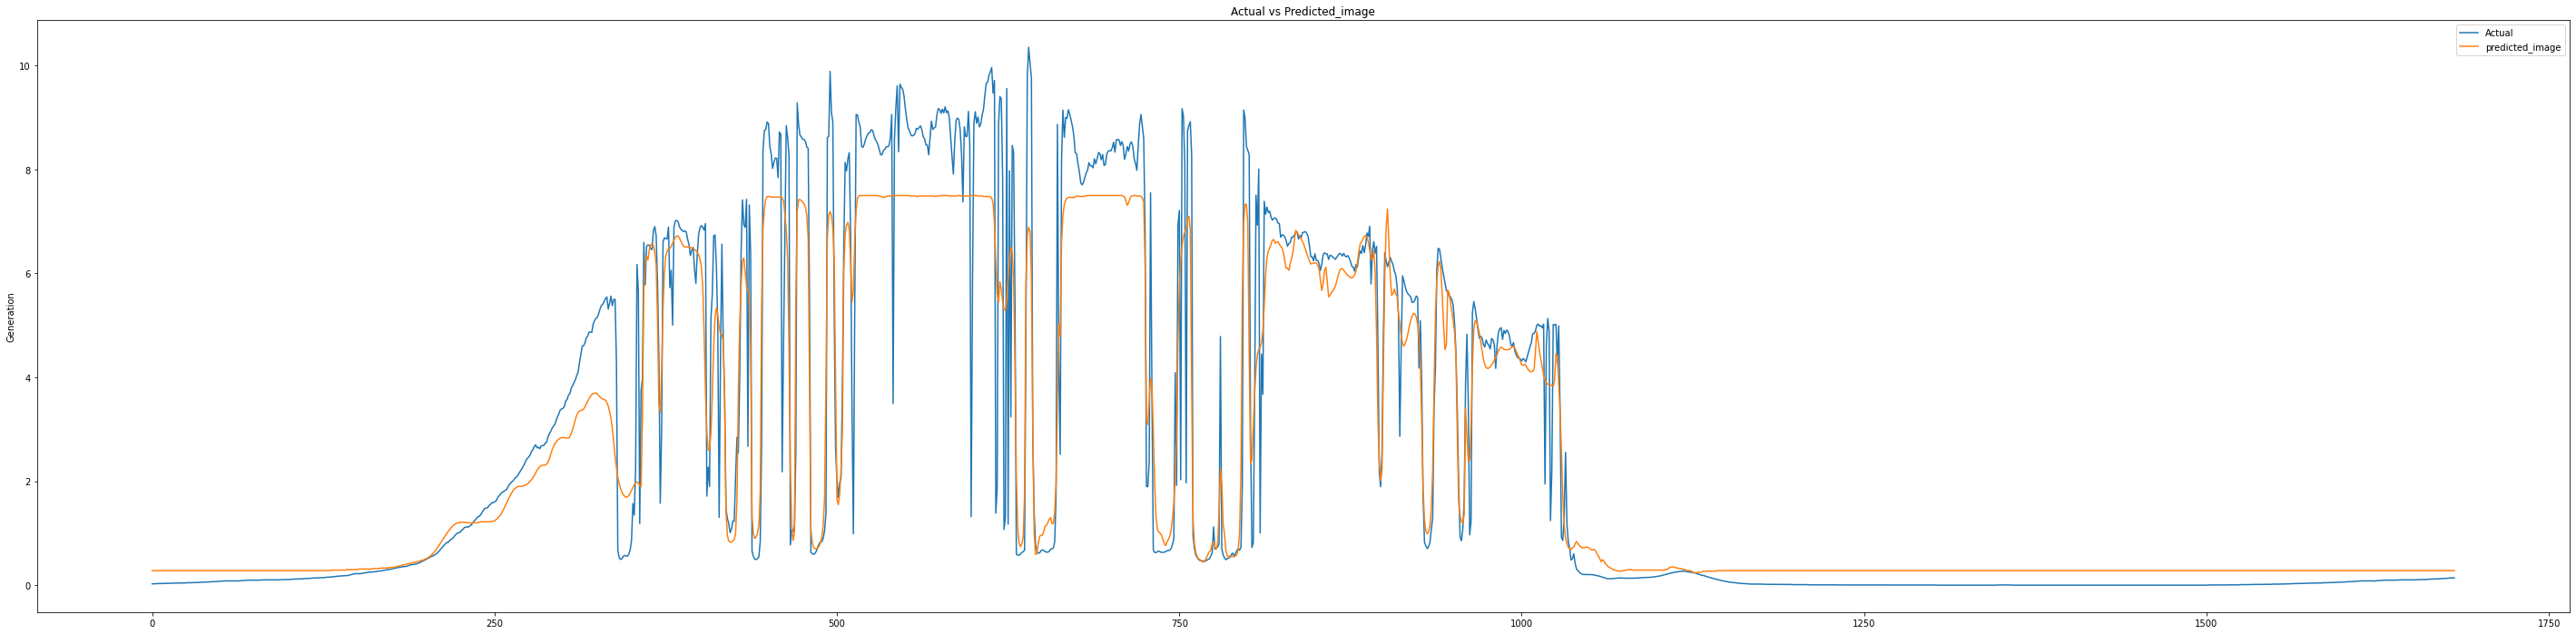

In [ ]:
plt.figure(figsize=(50,12))
#
plt.plot( list(Expected1))
plt.plot(predn)
# plt.plot(pred1)
plt.title("Actual vs Predicted_image")
plt.ylabel("Generation")
plt.legend(('Actual','predicted_image'))
plt.show()

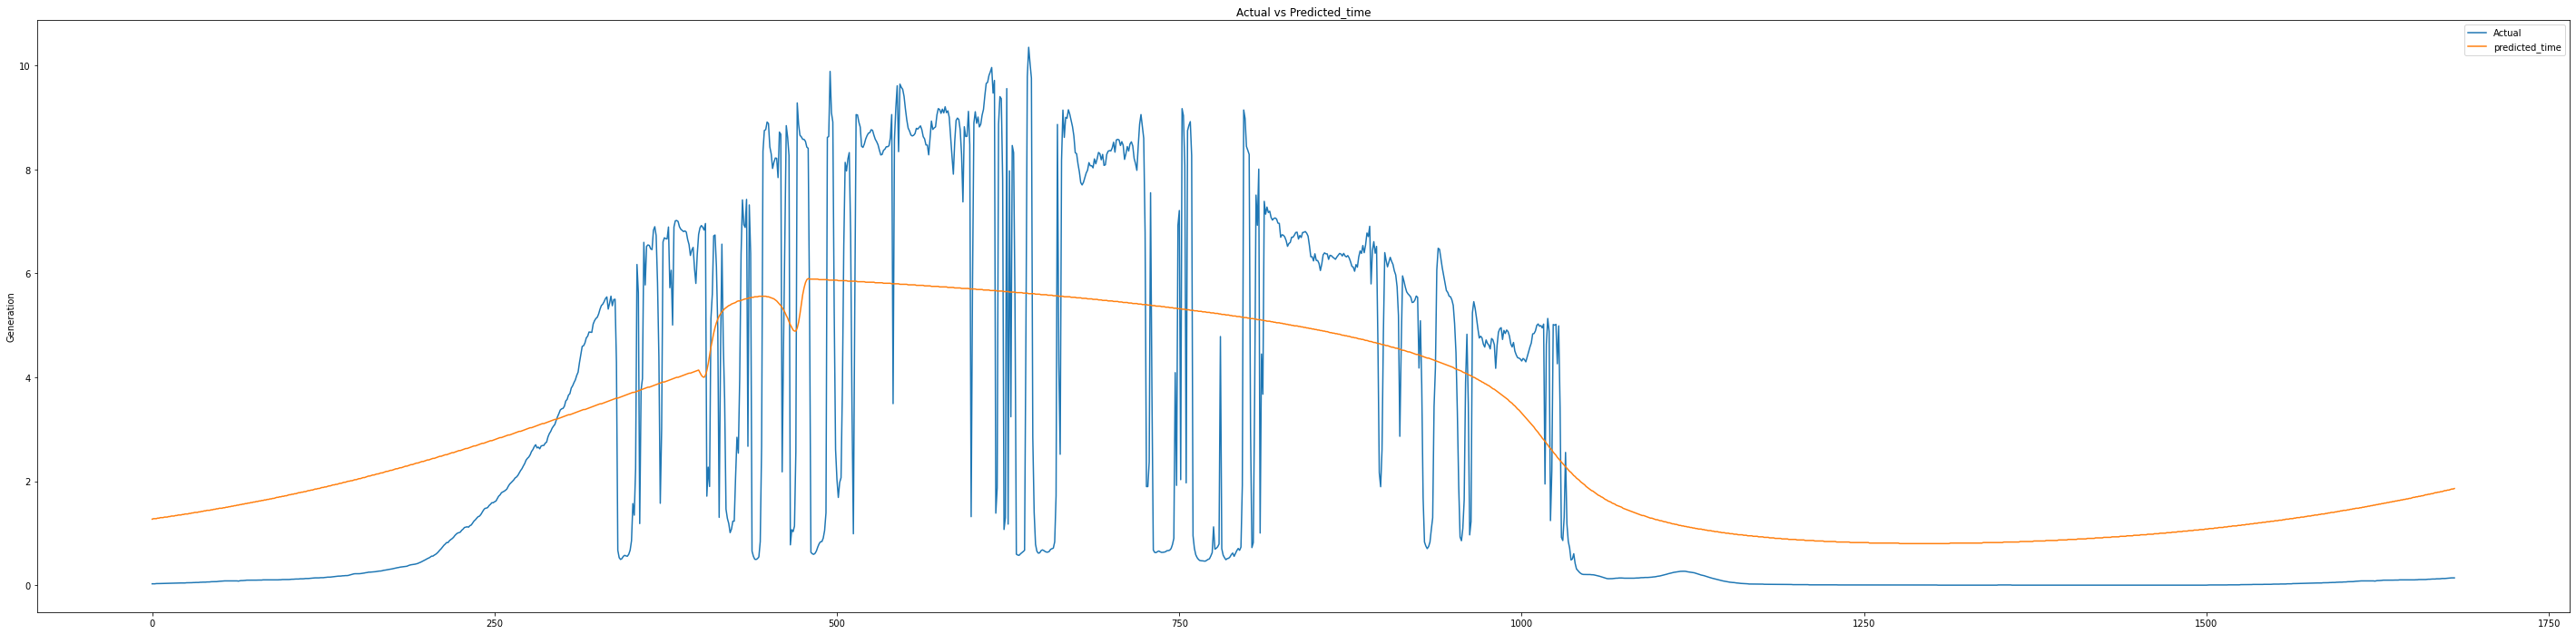

In [ ]:
plt.figure(figsize=(50,12))
#
plt.plot( list(Expected1))
plt.plot(predn1)
#plt.plot(pred1)
plt.title("Actual vs Predicted_time")
plt.ylabel("Generation")
plt.legend(('Actual','predicted_time'))
plt.show()

In [ ]:
rmse = []
for i in range(len(Expected1)):
  per_err = (Expected1[i][0] - predn[i])**2
  # print(per_err)
  rmse.append(per_err)
rmse = list(rmse)
rmse = (sum(rmse)/len(rmse))**0.5
print('rmse value sky imagery model',rmse)

rmse value sky imagery model 0.9085195317896558


In [ ]:
rmse = []
for i in range(len(predn1)):
  per_err = (Expected1[i][0] - predn1[i])**2
  rmse.append(per_err)
rmse = list(rmse)
rmse = (sum(rmse)/len(rmse))**0.5
print('rmse value statistical model',rmse)

rmse value statistical model 2.127773904155632


In [ ]:
mape = []
count = 0
for i in range(len(pred1)):
  if (Expected[i][0] > pred1[i]):
    count+=1
  per_err = (Expected[i][0] - pred1[i]) / pred1[i]
  per_err = abs(per_err)
  #print(Expected[i][0],pred[i],Expected[i][0]-pred[i], per_err)
  mape.append(per_err)
mape = list(mape)
mape = sum(mape)/len(mape)
mape

array([[6.472317]], dtype=float32)

In [ ]:
def rmse1(pred, expected):
  rmse = []

  for i in range(len(pred)):
    per_err = (Expected1[i][0] - pred[i])**2
    rmse.append(per_err)
  rmse = list(rmse)
  rmse = (sum(rmse)/len(rmse))**0.5
  return rmse

In [ ]:
predn1[0]*0.9

1.143

In [ ]:
ensemble = []
for i in range(len(pred)):
  ensemble.append((predn[i]*0.9+predn1[i]*0.1))
print(ensemble)
rmse1(ensemble,Expected1)


[0.37900000000000006, 0.38000000000000006, 0.38000000000000006, 0.38000000000000006, 0.38100000000000006, 0.38100000000000006, 0.38200000000000006, 0.38200000000000006, 0.38200000000000006, 0.38300000000000006, 0.38300000000000006, 0.38300000000000006, 0.38400000000000006, 0.38400000000000006, 0.38500000000000006, 0.38500000000000006, 0.38500000000000006, 0.38600000000000007, 0.38600000000000007, 0.38700000000000007, 0.38700000000000007, 0.38700000000000007, 0.38800000000000007, 0.38800000000000007, 0.38900000000000007, 0.38900000000000007, 0.38900000000000007, 0.39, 0.39, 0.391, 0.391, 0.392, 0.392, 0.392, 0.393, 0.393, 0.394, 0.394, 0.395, 0.395, 0.396, 0.396, 0.396, 0.397, 0.397, 0.398, 0.398, 0.399, 0.399, 0.4, 0.4, 0.4, 0.401, 0.401, 0.4020000000000001, 0.4020000000000001, 0.4030000000000001, 0.4030000000000001, 0.4040000000000001, 0.4040000000000001, 0.4050000000000001, 0.4050000000000001, 0.4060000000000001, 0.4060000000000001, 0.4070000000000001, 0.4070000000000001, 0.408000000

0.9675487254888046

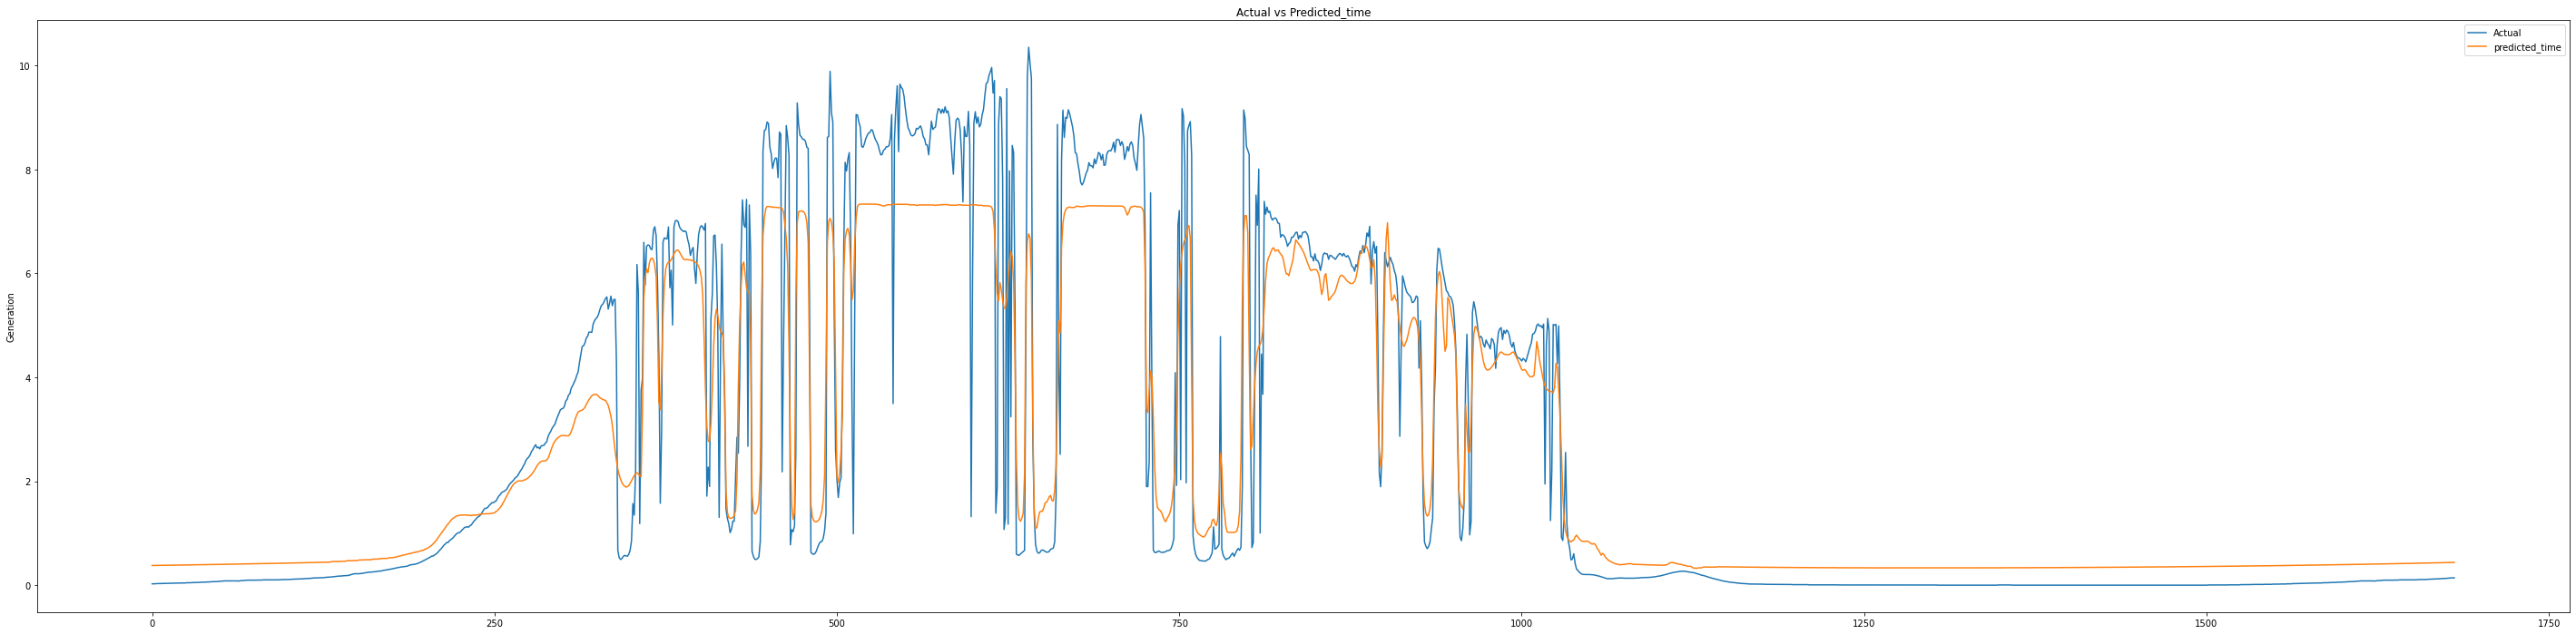

In [ ]:
plt.figure(figsize=(50,12))
#
plt.plot( list(Expected1))
plt.plot(ensemble)
#plt.plot(pred1)
plt.title("Actual vs Predicted_time")
plt.ylabel("Generation")
plt.legend(('Actual','predicted_time'))
plt.show()